## Compare RLAS, ROMY-Z, ADR and FFB1

### Import libraries

In [2]:
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_timeaxis import __get_timeaxis

In [3]:
def __get_stream(config):
    st = obs.Stream()

    for i in range(len(config.get("sta"))):

        seed = f'{config.get("net")[i]}.{config.get("sta")[i]}.{config.get("loc")}.{config.get("cha")}'

        print(f"loading {seed}...")

        st0, inv = __querrySeismoData(  
                                    seed_id=seed,
                                    starttime=config.get("tbeg"),
                                    endtime=config.get("tend"),
                                    where=config.get("repository"),
                                    path=None,
                                    restitute=True,
                                    detail=None,
                                    fill_value=None,
                                    )
        if len(st0) != 0:
            st += st0
    return st

### Configurations

In [4]:
config2 = {}

config2['tbeg'] = obs.UTCDateTime("2021-09-27 06:17")
config2['tend'] = obs.UTCDateTime("2021-09-27 06:40")

config2['seeds'] = {#'FUR': 'GR.FUR..BHZ',
                    'FFB1':'BW.FFB1..BHZ', 
                    'RLAS':'BW.RLAS..BJZ', 
                    'ROMY':'BW.ROMY.10.BJZ', 
                    'ADRZ':'BW.ROMY.20.BSZ',
                   }

config2['filter'] = {'type':'bandpass', 'fmin': 0.01, 'fmax': 0.2}

config2['repository'] = ["online", "online", "archive", "archive", "archive"]

### Load data

In [5]:
def __get_stream(config):
    
    st = obs.Stream()

    for i, seed in enumerate(config.get("seeds").keys()):

        seed = config.get("seeds")[seed]

        print(f"loading {seed}...")

        st0, inv = __querrySeismoData(  
                                    seed_id=seed,
                                    starttime=config.get("tbeg"),
                                    endtime=config.get("tend"),
                                    where=config.get("repository")[i],
                                    path=None,
                                    restitute=True,
                                    detail=None,
                                    fill_value=None,
                                    )
        if st0[0].stats.channel == "BSZ":
            st0[0].stats.station ="ADRZ"
        if len(st0) != 0:
            st += st0
    return st

st0 = __get_stream(config2)

loading BW.FFB1..BHZ...
loading BW.RLAS..BJZ...


/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/core/inventory/response.py:1193: UserWarning: The unit 'RAD/S' is not known to ObsPy. It will be assumed to be displacement for the calculations. This mostly does the right thing but please proceed with caution.
  warnings.warn(msg)


loading BW.ROMY.10.BJZ...
loading BW.ROMY.20.BSZ...
Coordinates could not be attached! Inventory not complete!


### Processing

In [6]:
st = st0.copy();

st.trim(starttime=config2.get("tbeg"), endtime=config2.get("tend"));

st.detrend('demean');

for tr in st:
    if tr.stats.sampling_rate > 20:
        tr.resample(20);
        
if config2['filter']:
    st.filter(config2['filter']['type'], 
              freqmin=config2['filter']['fmin'],
              freqmax=config2['filter']['fmax'], 
              corners=4, 
              zerophase=True);
print(st);

4 Trace(s) in Stream:
BW.FFB1..BHZ   | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:39:59.950000Z | 20.0 Hz, 27600 samples
BW.RLAS..BJZ   | 2021-09-27T06:16:59.982749Z - 2021-09-27T06:39:59.982749Z | 20.0 Hz, 27601 samples
BW.ROMY.10.BJZ | 2021-09-27T06:17:00.008799Z - 2021-09-27T06:40:00.008799Z | 20.0 Hz, 27601 samples
BW.ADRZ.20.BSZ | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:40:00.000000Z | 20.0 Hz, 27601 samples


/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


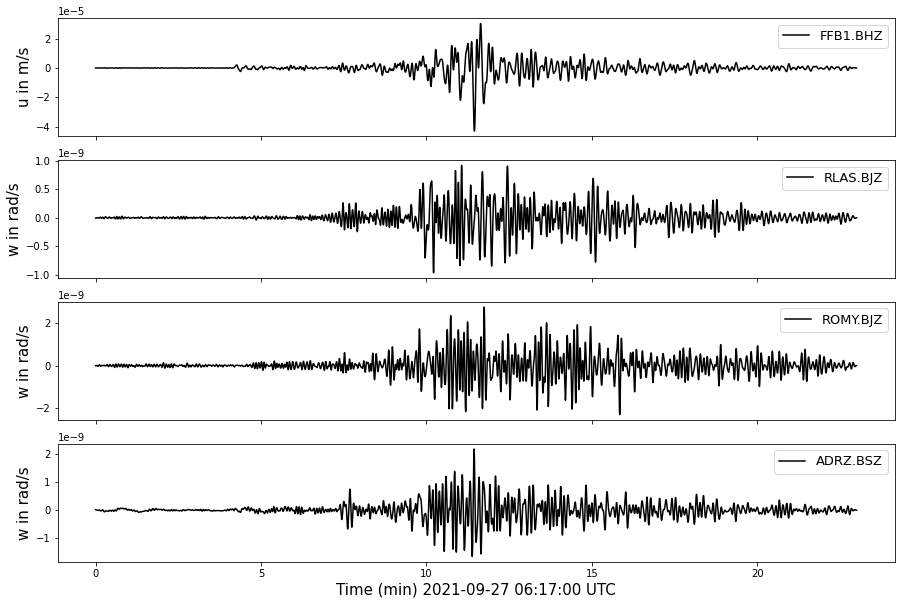

In [21]:
fig, ax = plt.subplots(len(st),1, figsize=(15,10), sharex=True)

font = 15

ylabels = ['u in m/s', 'w in rad/s', 'w in rad/s', 'w in rad/s']

for i, tr in enumerate(st):
    ax[i].plot(tr.times()/60, tr.data, color='k', label=f'{tr.stats.station}.{tr.stats.channel}');
    ax[i].legend(loc="upper right", fontsize=font-2)
    ax[i].set_ylabel(ylabels[i], fontsize=font)
    
    if i == len(st)-1:
        ax[i].set_xlabel(f"Time (min) {config2['tbeg'].date} {config2['tbeg'].time} UTC", fontsize=font)
    
fig.show();